# fixed n old


In [1]:
import numpy as np
import tensorflow as tf

from plotting import set_size, get_tex_fonts

import os
from itertools import product


from utils import calculate_rate, create_model
from data import create_dataset
from types import SimpleNamespace
import json

RELOAD = False

2022-04-15 18:05:02.468955: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
n_super_set = np.array([2, 3, 4, 5, 20, 30, 60])
n_set = np.array([3, 5, 20, 60])
snr_set = np.array([-1.5, 0, 1.5, 3])
#############################

# build the experiment set
experiment_set = []
for snr in snr_set:
    for n in n_set:
        max_k, _, _, c = calculate_rate(k=None, n=n, SNR=snr)
        # add all values of k from 1 to max k (determined by capacity)
        for k in range(1,max_k+1,2):
            experiment_set.append((k, n, snr))


In [3]:
exp = 'fixed_n_old'
data_dir = '/scratch/users/cmatson/nn-codes/data/'
experiment_dir = os.path.join(data_dir, f'experiment_{exp}')

In [4]:
if RELOAD:
    didnot = []
    performance_ber = []
    for test, (k, n, snr) in enumerate(experiment_set):

        if not os.path.exists(os.path.join(experiment_dir, f'test_{test}', 'val_history.npy')):
            print(f' {test} did not complete')
            didnot.append(test)
            continue
        hv = np.load(os.path.join(experiment_dir, f'test_{test}', 'val_history.npy'), allow_pickle=True).item()


        performance_ber.append(1-max(hv['binary_accuracy']))

        with open(os.path.join(experiment_dir, f'test_{test}', 'args.json')) as f:
            json_args = json.load(f)

        args = SimpleNamespace(**json_args)


        if False:
            fig, ax = plt.subplots(1,2, tight_layout=True)
            ax[0].plot(hv['loss'], label='loss')
            ax[0].set_title('loss')

            ax[1].plot(hv['binary_accuracy'], label='acc')
            ax[1].set_yscale('log')
            ax[1].set_title('acc')

            fig.suptitle(f'{k}/{n} @ snr {snr:.1f}')
    performance_ber = np.array(performance_ber)


In [5]:
if RELOAD:
    np.save(os.path.join(experiment_dir, 'performance_ber.npy'), performance_ber)
if not RELOAD:
    performance_ber = np.load(os.path.join(experiment_dir, 'performance_ber.npy'))

In [6]:
def get_test_idx(k=None, n=None, snr=None):
    if all(np.array([snr, k, n])==None):
        print('gotta give something')
        return -1
    idx = []
    for test, (test_k, test_n, test_snr) in enumerate(experiment_set):
        if test_k == k or k is None:
            if test_n == n or n is None:
                if test_snr == snr or snr is None:
                    idx.append(test)
    return np.array(idx), np.array(experiment_set)[idx]

In [7]:
def get_ber_from_training(k=None, n=None, snr=None):
    idx, params = get_test_idx(k, n, snr)
    if len(idx)==0 :
        return None, None
    ber = np.array([b for b in np.array(performance_ber)[idx]])    
    return ber, params

In [8]:
turboae_13 = np.array([4.1e-2, 3.0e-2, 1e-2, 3.0e-3, 8e-4, 2.5e-4, 7e-5, 3.1e-5, 6e-6, 2e-6])

turboae_12 = np.array([None, None, None, 1.5e-1, None, 7e-2, None,  1e-2, None, 1e-3])

In [9]:
import matplotlib.pyplot as plt
PUBLISH=True
if PUBLISH:
    plt.rcParams.update(get_tex_fonts())
else:
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'figure.figsize':(6,4)})
%matplotlib inline


In [10]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.grid.which':

In [11]:
n_super_set

array([ 2,  3,  4,  5, 20, 30, 60])

In [12]:
n_set

array([ 3,  5, 20, 60])

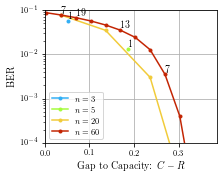

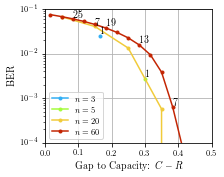

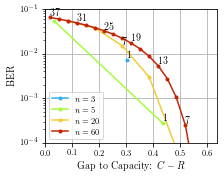

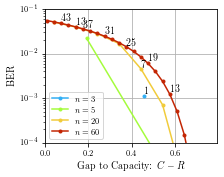

In [15]:
from matplotlib.cm import turbo
cidx = np.linspace(0.1, 0.9, len(n_super_set))
for snr in snr_set:
    if PUBLISH:
        fig, ax = plt.subplots(1, 1, figsize=set_size(width='conference', fraction=0.45), tight_layout=True)
    else:
        fig, ax = plt.subplots(1, 1, tight_layout=True)


    for j, n in enumerate(n_set):
        ber, params = get_ber_from_training(n=n, snr=snr)
        if ber is None:
            continue
        k_set = params[:,0]
        r_set = [k/n for k in k_set]
        
        _, _, _, c = calculate_rate(k=None, n=n, SNR=snr)
        
        gp = np.array(r_set)*(1-ber)
        ax.plot([c-r for r in r_set], ber, 'o-', color=turbo(cidx[n_super_set==n_set[j]]), label=f'$n={n}$')
        
        for i, k in enumerate(k_set):
            if i%3 != 0:
                continue
            ax.annotate(str(int(k)), ((c-r_set[i]), 1.1*(ber[i])))

    ax.set_yscale('log')
    ax.set_ylim([1e-4,1e-1])
#     ax.invert_xaxis()
    ax.legend(loc='lower left')
    ax.set_xlabel('Gap to Capacity: $C-R$')
    ax.set_xlim([0, c])
    ax.set_ylabel('BER')
    ax.grid('on')
    if PUBLISH:
        fig.savefig(f'./figures/fixed_n_c{c:.3f}_snr{snr:.3f}.pdf')



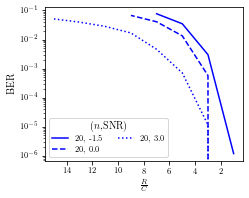

In [21]:
# from matplotlib.cm import turbo
# cidx = np.linspace(0.1, 0.9, len(n_super_set))
# if PUBLISH:
#     fig, ax = plt.subplots(1, 1, figsize=set_size(width='conference', fraction=0.5), tight_layout=True)
# else:
#     fig, ax = plt.subplots(1, 1, figsize=(8,6),tight_layout=True)
# # axin = ax.inset_axes([0.05, .2, .5, .3])
    
# linestyle = ['-', '--', ':']
# color=['b', 'r','g']
# # for j, n in enumerate([20, 60]):
# for j,n in enumerate([20]):
#     for l, snr in enumerate([-1.5, 0, 3]):
#         ber, params = get_ber_from_training(n=n, snr=snr)
#         if ber is None:
#             continue
#         k_set = params[:,0]
#         r_set = [k/n for k in k_set]

#         _, _, _, c = calculate_rate(k=None, n=n, SNR=snr)

#         gp = np.array(r_set)*(1-ber)
# #         ax.plot([r/c for r in r_set], ber, linestyle[l],  color=color[j], label=f'${n},{snr}$')
#         ax.plot([k for k in k_set], ber, linestyle[l], color=color[j], label=f'{n}, {snr: .1f}')
#         for i, k in enumerate(k_set):
#             if i%3!=0:
#                 continue
# #             ax.annotate(str(int(k)), ((c-r_set[i]), 1.1*(ber[i])), color='k'if l ==0 else 'b')

# #         axin.plot([r/c for r in r_set], ber, linestyle[l],  color=color[j])
    
# #     axin.set_yscale('log')
# #     axin.set_xlim([0, 0.25])
# #     axin.set_ylim([2e-2,1e-1])
# #     axin.set_xticklabels([])
# #     axin.set_yticklabels([])
    
# ax.set_yscale('log')
# ax.invert_xaxis()
# ax.legend(ncol=2,title='$(n, $SNR$)$')
# ax.set_xlabel('$\\frac{R}{C}$')
# ax.set_ylabel('BER')

    
# #     axin.plot[r/c for r in r_set], ber, linestyle[l],  color=color[j]
# #     ax.indicate_inset_zoom(axin)
    
# if PUBLISH:
#     fig.savefig(f'./figures/fixed_n_multi_snr.pdf')

